<a href="https://colab.research.google.com/github/mkkim007/AIFFEL/blob/main/%5BE_07%5DIMDb(MovieReviewSentimentAnalysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [E-07] 영화리뷰 텍스트 감정분석하기

# 0. 시작하기전.. 

여태까지 영어로만 자연어 처리를 해보았다...  
한국어로 자연어 처리를 하기위해서는 이것저것 깔아야한다.  

[참고](https://sanghyu.tistory.com/170)

In [1]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [2]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [3]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

Installing automake (A dependency for mecab-ko)
Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.l

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 5.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  2257k      0 --:--:-- --:--:-- --:--:-- 2257k
./configure: line 7378: /usr/bin/file: No such file or directory
In file included from viterbi.cpp:14:0:
param.h:30:13: warning: 'Target {anonymous}::lexical_cast(Source) [with Target = std::__cxx11::basic_string<char>; Source = std::_

## 1. 데이터 준비와 확인

In [4]:
! sudo apt-get install git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.17.1-1ubuntu0.8).
0 upgraded, 0 newly installed, 0 to remove and 104 not upgraded.


In [5]:
! git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 18.72 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [7]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt  #한국어 정보처리를 위한 파이썬 패키지
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 

train_data = pd.read_table('/content/nsmc/ratings_train.txt')
test_data = pd.read_table('/content/nsmc/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


---

## 2. 데이터 로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화 (Mecab)  [다양한 한국어 토크나이저](https://mr-doosun.tistory.com/22)
- 불용어(Stopwords)제거
- 사전 `word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- Retrun `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 

In [8]:
from konlpy.tag import Mecab
# Mecab : 일본어용 형태소 분석기를 한국어에 사용할 수 있도록 수정한 것 
tokenizer = Mecab()

# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # NaN 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any') 

 
    X_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        X_train.append(temp_x)
    
    X_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) #토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        X_test.append(temp_x)

    words = np.concatenate(X_train).tolist() # concatenate : numpy 배열 합치기
    counter = Counter(words)    # 글자 수 세기
    counter = counter.most_common(10000-4)  # 데이터의 개수가 많은 순으로 정렬한 후 10000-4개만 저장 (4개는 스페셜 토큰!!)
    
    # 스페셜 토큰들,,
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]

    # {'글자': 1}
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlis_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlis_to_indexlist, X_train))
    X_test = list(map(wordlis_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)


In [9]:
# {1:'글자'}
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델구성을 위한 데이터 분석 및 가공

### 3.1 데이터셋 내 문장 길이 분포

In [11]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [12]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.969355837799927
문장길이 최대 :  116
문장길이 표준편차 :  12.843536204665021


In [13]:
for i in enumerate(num_tokens) : 
    if i[1] == 116 :
        print(i[0])
print(X_train[34669])
index_to_word[4]

34669
[310, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2797]


'.'

.이 엄청 많네요,, 이게 나중에 영향을 끼칠지,,, 일단 그냥 두고 넘어갑시다~!~!

### 3.2 적절한 최대 문장 길이 지정

In [14]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면, 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 3.3 keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [15]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

## 4. validation set 구성

In [16]:
# 약 8:2 비율로 
# validation set 30000건 분리
X_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)


(116182, 41)
(116182,)


## 4. 모델 구성 및 학습

### 4.1 LSTM

#### 4.1.1 모델 구성

In [17]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 20  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          200000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 928       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 201,009
Trainable params: 201,009
Non-trainable params: 0
_________________________________________________________________


#### 4.1.2 모델 컴파일 및 학습

In [18]:
#옵티마이저 설명 https://onevision.tistory.com/entry/Optimizer-%EC%9D%98-%EC%A2%85%EB%A5%98%EC%99%80-%ED%8A%B9%EC%84%B1-Momentum-RMSProp-Adam

model.compile(optimizer='rmsprop',      # 태원님의 꿀팁! 
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 13s 47ms/step - loss: 0.5023 - accuracy: 0.7800 - val_loss: 0.3866 - val_accuracy: 0.8367
Epoch 2/10
227/227 [==============================] - 9s 40ms/step - loss: 0.3555 - accuracy: 0.8509 - val_loss: 0.3549 - val_accuracy: 0.8471
Epoch 3/10
227/227 [==============================] - 10s 42ms/step - loss: 0.3283 - accuracy: 0.8623 - val_loss: 0.3388 - val_accuracy: 0.8536
Epoch 4/10
227/227 [==============================] - 10s 43ms/step - loss: 0.3144 - accuracy: 0.8684 - val_loss: 0.3375 - val_accuracy: 0.8558
Epoch 5/10
227/227 [==============================] - 10s 45ms/step - loss: 0.3048 - accuracy: 0.8727 - val_loss: 0.3436 - val_accuracy: 0.8536
Epoch 6/10
227/227 [==============================] - 9s 41ms/step - loss: 0.2968 - accuracy: 0.8766 - val_loss: 0.3386 - val_accuracy: 0.8549
Epoch 7/10
227/227 [==============================] - 10s 43ms/step - loss: 0.2895 - accuracy: 0.8795 - val_loss: 0.3367 - val_accuracy: 0

#### 4.1.3 모델 평가

In [19]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3521 - accuracy: 0.8504
[0.35212212800979614, 0.8503977060317993]


In [20]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


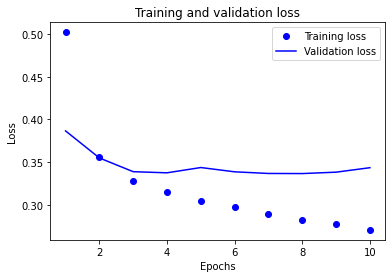

In [21]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

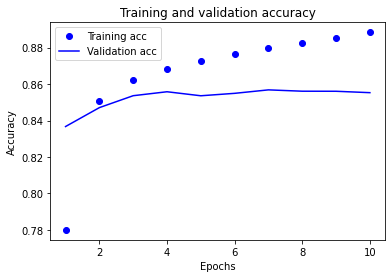

In [22]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 4.2 1-D Convolution Neural Network(1-D CNN)

#### 4.2.1 모델 구성

In [23]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 20   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 20)          200000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          2256      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

#### 4.2.2 모델 컴파일 및 학습

In [24]:
model.compile(optimizer='rmsprop',      # 태원님의 꿀팁! 
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 10s 41ms/step - loss: 0.5063 - accuracy: 0.7560 - val_loss: 0.3657 - val_accuracy: 0.8411
Epoch 2/10
227/227 [==============================] - 9s 39ms/step - loss: 0.3452 - accuracy: 0.8514 - val_loss: 0.3423 - val_accuracy: 0.8511
Epoch 3/10
227/227 [==============================] - 9s 38ms/step - loss: 0.3180 - accuracy: 0.8652 - val_loss: 0.3331 - val_accuracy: 0.8560
Epoch 4/10
227/227 [==============================] - 8s 33ms/step - loss: 0.2994 - accuracy: 0.8750 - val_loss: 0.3293 - val_accuracy: 0.8578
Epoch 5/10
227/227 [==============================] - 8s 34ms/step - loss: 0.2837 - accuracy: 0.8826 - val_loss: 0.3260 - val_accuracy: 0.8600
Epoch 6/10
227/227 [==============================] - 7s 31ms/step - loss: 0.2682 - accuracy: 0.8901 - val_loss: 0.3274 - val_accuracy: 0.8611
Epoch 7/10
227/227 [==============================] - 7s 30ms/step - loss: 0.2516 - accuracy: 0.8977 - val_loss: 0.3271 - val_accuracy: 0.862

#### 4.2.3 모델 평가

In [25]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3716 - accuracy: 0.8496
[0.3715726137161255, 0.8495839834213257]


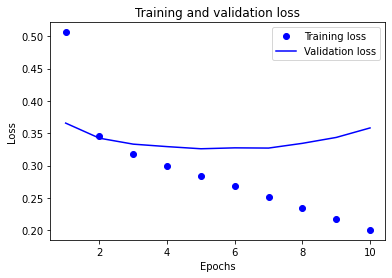

In [26]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

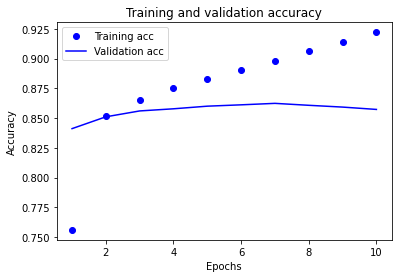

In [27]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 4.3 GlobalMaxPooling1D

#### 4.3.1 모델 구성

In [28]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 20   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 20)          200000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 200,177
Trainable params: 200,177
Non-trainable params: 0
_________________________________________________________________


#### 4.3.2 모델 컴파일 및 학습

In [29]:
model.compile(optimizer='rmsprop',      # 태원님의 꿀팁! 
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 5s 21ms/step - loss: 0.5923 - accuracy: 0.7702 - val_loss: 0.4651 - val_accuracy: 0.8106
Epoch 2/10
227/227 [==============================] - 4s 19ms/step - loss: 0.4052 - accuracy: 0.8275 - val_loss: 0.3756 - val_accuracy: 0.8315
Epoch 3/10
227/227 [==============================] - 4s 16ms/step - loss: 0.3539 - accuracy: 0.8467 - val_loss: 0.3577 - val_accuracy: 0.8411
Epoch 4/10
227/227 [==============================] - 4s 18ms/step - loss: 0.3325 - accuracy: 0.8578 - val_loss: 0.3505 - val_accuracy: 0.8441
Epoch 5/10
227/227 [==============================] - 3s 13ms/step - loss: 0.3188 - accuracy: 0.8645 - val_loss: 0.3484 - val_accuracy: 0.8476
Epoch 6/10
227/227 [==============================] - 3s 15ms/step - loss: 0.3092 - accuracy: 0.8693 - val_loss: 0.3481 - val_accuracy: 0.8478
Epoch 7/10
227/227 [==============================] - 4s 16ms/step - loss: 0.3019 - accuracy: 0.8737 - val_loss: 0.3486 - val_accuracy: 0.8486

#### 4.3.3 모델 평가

In [30]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.3611 - accuracy: 0.8464
[0.36105233430862427, 0.8464308381080627]


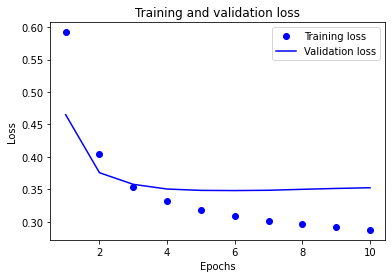

In [31]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

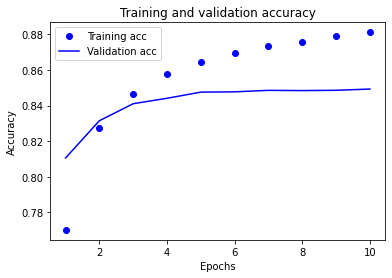

In [32]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 5. Word2Vec 적용

### 5.1위에서 사용했던 워드 벡터 확인해보기

In [36]:
!mkdir /content/data
#!pip list | grep gensim

In [37]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 20)


In [38]:
word2vec_file_path = '/content/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [39]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['love']
vector

array([ 0.19975184, -0.07982546,  0.15606727, -0.06632871, -0.04428791,
        0.00475706,  0.13818711, -0.09232894, -0.03867043,  0.00086683,
        0.04528707,  0.14478683,  0.01797735, -0.06790008, -0.0742427 ,
        0.07794393, -0.05910066, -0.05794249, -0.08736402, -0.09865344],
      dtype=float32)

In [40]:
word_vectors.similar_by_word("love")

[('센', 0.9049975872039795),
 ('달달', 0.9046398997306824),
 ('케미', 0.9017515778541565),
 ('귀여우', 0.9012712240219116),
 ('눈빛', 0.8950306177139282),
 ('최고봉', 0.8920006155967712),
 ('아름다워요', 0.8874927759170532),
 ('통쾌', 0.8860470056533813),
 ('맛깔', 0.8856925368309021),
 ('여운', 0.8847660422325134)]

### 5.2 word2vec 모델 불러오기

In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [42]:
!cp /content/gdrive/MyDrive/Data/GoogleNews-vectors-negative300.bin.gz /content/data

In [43]:
from gensim.models import KeyedVectors
word2vec_path = '/content/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [44]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

### 5.3 1-D CNN

#### 5.3.1 모델 구성

In [53]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

#### 5.3.2 모델 컴파일 및 학습

In [54]:
# 학습의 진행
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 76s 330ms/step - loss: 0.6723 - accuracy: 0.5714 - val_loss: 0.5730 - val_accuracy: 0.7428
Epoch 2/10
227/227 [==============================] - 74s 326ms/step - loss: 0.5024 - accuracy: 0.7630 - val_loss: 0.4775 - val_accuracy: 0.7736
Epoch 3/10
227/227 [==============================] - 74s 327ms/step - loss: 0.4217 - accuracy: 0.8107 - val_loss: 0.3926 - val_accuracy: 0.8272
Epoch 4/10
227/227 [==============================] - 75s 331ms/step - loss: 0.3861 - accuracy: 0.8302 - val_loss: 0.4316 - val_accuracy: 0.8067
Epoch 5/10
227/227 [==============================] - 77s 339ms/step - loss: 0.3644 - accuracy: 0.8419 - val_loss: 0.3764 - val_accuracy: 0.8357
Epoch 6/10
227/227 [==============================] - 74s 325ms/step - loss: 0.3499 - accuracy: 0.8502 - val_loss: 0.4106 - val_accuracy: 0.8177
Epoch 7/10
227/227 [==============================] - 73s 320ms/step - loss: 0.3393 - accuracy: 0.8553 - val_loss: 0.3567 - val_ac

#### 5.3.3 모델 평가

In [55]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 8s - loss: 0.3598 - accuracy: 0.8441
[0.35978230834007263, 0.8441320657730103]


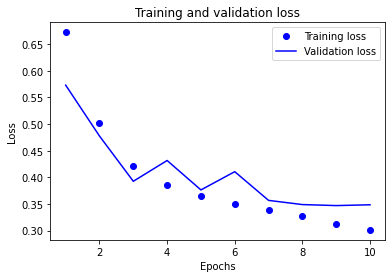

In [56]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

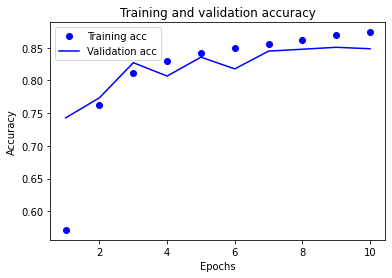

In [57]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 5.4 LSTM

#### 5.4.1 모델 구성

In [58]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


#### 5.4.2 모델 컴파일 및 학습

In [59]:
# 학습의 진행
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 47s 197ms/step - loss: 0.5433 - accuracy: 0.7323 - val_loss: 0.4813 - val_accuracy: 0.7836
Epoch 2/10
227/227 [==============================] - 43s 192ms/step - loss: 0.3868 - accuracy: 0.8338 - val_loss: 0.3672 - val_accuracy: 0.8405
Epoch 3/10
227/227 [==============================] - 44s 195ms/step - loss: 0.3394 - accuracy: 0.8567 - val_loss: 0.3494 - val_accuracy: 0.8498
Epoch 4/10
227/227 [==============================] - 42s 183ms/step - loss: 0.3175 - accuracy: 0.8663 - val_loss: 0.3415 - val_accuracy: 0.8512
Epoch 5/10
227/227 [==============================] - 40s 175ms/step - loss: 0.3023 - accuracy: 0.8734 - val_loss: 0.3325 - val_accuracy: 0.8572
Epoch 6/10
227/227 [==============================] - 39s 173ms/step - loss: 0.2908 - accuracy: 0.8799 - val_loss: 0.3325 - val_accuracy: 0.8592
Epoch 7/10
227/227 [==============================] - 41s 180ms/step - loss: 0.2804 - accuracy: 0.8850 - val_loss: 0.3350 - val_ac

#### 5.4.3 모델 평가

In [60]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 10s - loss: 0.3374 - accuracy: 0.8571
[0.3374311327934265, 0.8571312427520752]


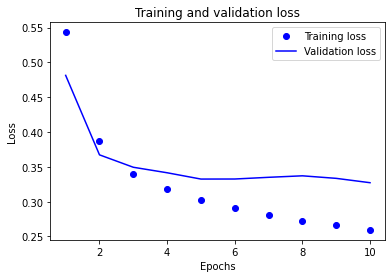

In [61]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

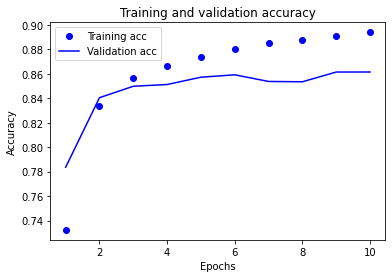

In [62]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 5.5 Layer Norm LSTM

In [63]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
from keras.regularizers import l2

     |████████████████████████████████| 679 kB 5.1 MB/s 


#### 5.5.1 모델 구성

In [64]:
# 형준님 감사합니다 ㅎㅎ
from tensorflow.keras.initializers import Constant
from keras.regularizers import l2
import tensorflow as tf

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 



# 노드에서 달라진 부분
lnLSTMCell = tfa.rnn.LayerNormLSTMCell(20, recurrent_dropout=0.2, dropout=0.15, kernel_regularizer=l2(0.015), recurrent_regularizer=l2(0.015))


rnn = tf.keras.layers.RNN(lnLSTMCell, return_sequences=False, return_state=False)
# 노드에서 달라진 부분




# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(rnn)  # 위에서 정의한 레이어를 쌓아 줍니다
model.add(keras.layers.Dense(30, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
rnn (RNN)                    (None, 20)                26040     
_________________________________________________________________
dense_14 (Dense)             (None, 30)                630       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 31        
Total params: 3,026,701
Trainable params: 3,026,701
Non-trainable params: 0
_________________________________________________________________


#### 5.5.2 모델 컴파일 및 학습

In [66]:
# 학습의 진행
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/7
227/227 [==============================] - 114s 485ms/step - loss: 1.0845 - accuracy: 0.6390 - val_loss: 0.6406 - val_accuracy: 0.7628
Epoch 2/7
227/227 [==============================] - 109s 482ms/step - loss: 0.5671 - accuracy: 0.7807 - val_loss: 0.4789 - val_accuracy: 0.8226
Epoch 3/7
227/227 [==============================] - 107s 470ms/step - loss: 0.4587 - accuracy: 0.8290 - val_loss: 0.4162 - val_accuracy: 0.8464
Epoch 4/7
227/227 [==============================] - 104s 457ms/step - loss: 0.4129 - accuracy: 0.8450 - val_loss: 0.3952 - val_accuracy: 0.8484
Epoch 5/7
227/227 [==============================] - 103s 452ms/step - loss: 0.3898 - accuracy: 0.8521 - val_loss: 0.4305 - val_accuracy: 0.8340
Epoch 6/7
227/227 [==============================] - 105s 463ms/step - loss: 0.3727 - accuracy: 0.8582 - val_loss: 0.3822 - val_accuracy: 0.8498
Epoch 7/7
227/227 [==============================] - 108s 475ms/step - loss: 0.3610 - accuracy: 0.8627 - val_loss: 0.3641 - val_ac

#### 5.5.3 모델 평가

In [67]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 42s - loss: 0.3766 - accuracy: 0.8517
[0.37662947177886963, 0.8516589999198914]


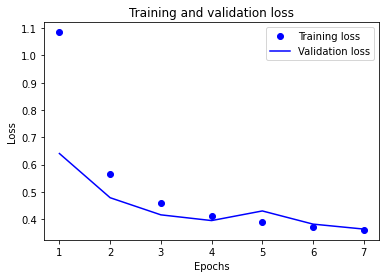

In [68]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

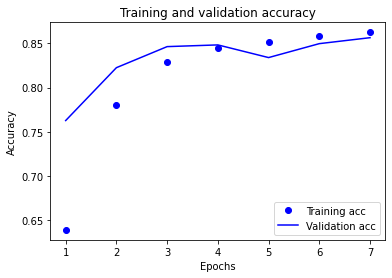

In [69]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 회고
- keras에서 제공하는 임베딩으로 했을때 정확도는

    LSTM : __0.8504__   
    1-D CNN : 0.8496  
    Global Max Polling 1D : 0.8464 
    
    LSTM이 가장 높게 나왔다. 

- Word2vec 임베딩을 가져왔을 때 정확도는  

    1-D CNN : 0.8441   
    LSTM : __0.8571__  
    Norm LSTM : __0.8517__ (굉장히 느림 ㅜ) 

    마찬가지로 LSTM이 가장 높다

- Word2Vec를 쓰는 것이 조금 더 좋은 성능을 보여주고 있다.

-  Norm LSTM(Layer Normalization을 적용한 LSTM 레이어)를 쓰면 더 좋아야하는데 그렇지 않은게 의문이다.... 



# 저는 바보 입니다


영어 임베딩가지고 학습시켰다,,ㅋㅋㅋ 근데 되는게 신기하다,, NLP,, 알면알수록 재밌는 녀석,,  
한국어 임베딩 모델을 가져오려면 https://github.com/Kyubyong/wordvectors 에서 다운받으면 된다!!  
그리고 꼭 gensim을 3.8로 다운그레이드 해줘야한다,,, 

In [6]:
!pip install --upgrade gensim==3.8.3

     |████████████████████████████████| 24.2 MB 101 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [70]:
!cp /content/gdrive/MyDrive/Data/ko.zip /content/data
!unzip /content/data/ko.zip -d /content/data

Archive:  /content/data/ko.zip
  inflating: /content/data/ko.bin    
  inflating: /content/data/ko.tsv    


In [71]:
from gensim.models import KeyedVectors
import gensim
word2vec_path = '/content/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)


In [72]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


### LSTM

In [73]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [74]:
# 학습의 진행
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/7
227/227 [==============================] - 35s 144ms/step - loss: 0.5337 - accuracy: 0.7317 - val_loss: 0.4233 - val_accuracy: 0.8112
Epoch 2/7
227/227 [==============================] - 30s 130ms/step - loss: 0.3930 - accuracy: 0.8271 - val_loss: 0.3777 - val_accuracy: 0.8345
Epoch 3/7
227/227 [==============================] - 28s 123ms/step - loss: 0.3528 - accuracy: 0.8478 - val_loss: 0.3685 - val_accuracy: 0.8401
Epoch 4/7
227/227 [==============================] - 29s 128ms/step - loss: 0.3287 - accuracy: 0.8609 - val_loss: 0.3440 - val_accuracy: 0.8520
Epoch 5/7
227/227 [==============================] - 27s 119ms/step - loss: 0.3129 - accuracy: 0.8697 - val_loss: 0.3429 - val_accuracy: 0.8550
Epoch 6/7
227/227 [==============================] - 29s 127ms/step - loss: 0.3006 - accuracy: 0.8746 - val_loss: 0.3377 - val_accuracy: 0.8563
Epoch 7/7
227/227 [==============================] - 28s 125ms/step - loss: 0.2909 - accuracy: 0.8798 - val_loss: 0.3332 - val_accuracy:

In [75]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 8s - loss: 0.3440 - accuracy: 0.8548
[0.3439599573612213, 0.8547511100769043]


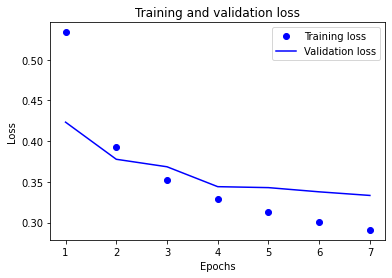

In [77]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

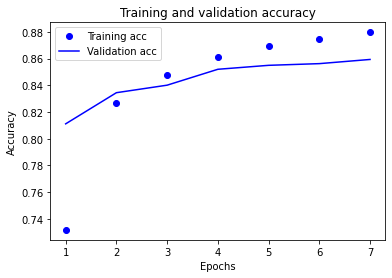

In [78]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Layer Norm LSTM

In [80]:

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 



# 노드에서 달라진 부분
lnLSTMCell = tfa.rnn.LayerNormLSTMCell(20, recurrent_dropout=0.2, dropout=0.15, kernel_regularizer=l2(0.015), recurrent_regularizer=l2(0.015))


rnn = tf.keras.layers.RNN(lnLSTMCell, return_sequences=False, return_state=False)
# 노드에서 달라진 부분




# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(rnn)  # 위에서 정의한 레이어를 쌓아 줍니다
model.add(keras.layers.Dense(30, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
rnn_2 (RNN)                  (None, 20)                18040     
_________________________________________________________________
dense_18 (Dense)             (None, 30)                630       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 31        
Total params: 2,018,701
Trainable params: 2,018,701
Non-trainable params: 0
_________________________________________________________________


In [81]:
# 학습의 진행
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/7
227/227 [==============================] - 90s 379ms/step - loss: 1.2353 - accuracy: 0.7040 - val_loss: 0.6566 - val_accuracy: 0.7851
Epoch 2/7
227/227 [==============================] - 82s 360ms/step - loss: 0.5606 - accuracy: 0.8019 - val_loss: 0.4950 - val_accuracy: 0.8141
Epoch 3/7
227/227 [==============================] - 83s 368ms/step - loss: 0.4584 - accuracy: 0.8287 - val_loss: 0.4117 - val_accuracy: 0.8490
Epoch 4/7
227/227 [==============================] - 84s 371ms/step - loss: 0.4151 - accuracy: 0.8426 - val_loss: 0.3939 - val_accuracy: 0.8506
Epoch 5/7
227/227 [==============================] - 86s 379ms/step - loss: 0.3917 - accuracy: 0.8506 - val_loss: 0.3746 - val_accuracy: 0.8573
Epoch 6/7
227/227 [==============================] - 85s 373ms/step - loss: 0.3761 - accuracy: 0.8569 - val_loss: 0.3722 - val_accuracy: 0.8568
Epoch 7/7
227/227 [==============================] - 86s 378ms/step - loss: 0.3652 - accuracy: 0.8607 - val_loss: 0.3643 - val_accuracy:

In [84]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 34s - loss: 0.3705 - accuracy: 0.8542
[0.3704991638660431, 0.8542425036430359]


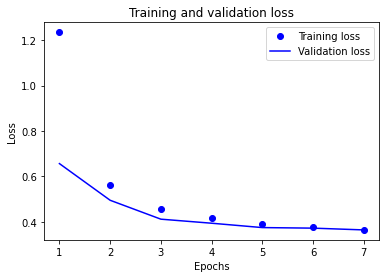

In [82]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

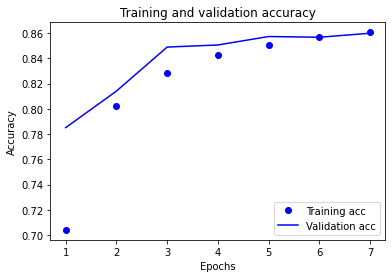

In [83]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

근데 이거나,, 저거나,, 성능은 비슷해 보인다 